In [1]:
import sys
plist = ['/Applications/NEURON/lib/python']
for pd in plist:
    if pd in sys.path:
        sys.path.remove(pd)

from neuron import h, gui, rxd
from neuron.units import mV,ms
import matplotlib.pyplot as plt
import plotly
from neuron import h
import numpy as np
import math

In [2]:
# load morphology file
h.load_file("stdlib.hoc")
h.load_file("import3d.hoc")
h.load_file("stdrun.hoc")

cell = h.Import3d_SWC_read()
cell.input("./file-swc/c91662.CNG.swc")
h.Import3d_GUI(cell, 0)
i3d = h.Import3d_GUI(cell, 0)
i3d.instantiate(None)

0.0

In [3]:
def calseg(L):
    return 1 + 2 * int(L / 20)

for sec in h.allsec():
    sec.nseg = calseg(sec.L)

tt = 100 * ms # runtime
approxend = 1-1e-3

In [4]:
from importlib.resources import path

soma = h.soma[0] # define soma

thedendlst = h.dend # define dendrite list in the morphology
theapiclst = h.apic # define apical dendrite list in the morphology

wholedendlst = []
for aa in thedendlst:
    wholedendlst.append(aa)
for ll in theapiclst:
    wholedendlst.append(ll)

dendlst = h.dend

print(len(dendlst))

# == start experiment == # 

# add HH channel into the soma
addhh = 1
if addhh == 1:
    soma.insert('hh')
    for seg in soma:
        seg.hh.gnabar = 0.12 # Sodium conductance, S/cm2
        seg.hh.gkbar = 0.036 # Potassium conductance, S/cm2
        seg.hh.gl = 0.0003 # Leak conductance, S/cm2
        seg.hh.el = -54.3 # Reversal potential, mV

def my_initial(node):
    # some distance function
    return 2 * h.tanh(h.distance(soma(0.5),node) / 1000.0)

# add 1 spine
def add_spine(cp,cloc):
    shead = h.Section(name='spine head')
    shead.diam = 0.75
    shead.L = 0.5
    shead.Ra = 100 # Ohm * cm
    shead.nseg = calseg(shead.L)
    shead.insert('pas')

    sneck = h.Section(name='spine neck')
    sneck.diam = 0.2
    sneck.L = 0.5
    sneck.Ra = 100 # Ohm * cm
    sneck.nseg = calseg(sneck.L)
    sneck.insert('pas')

    shead.connect(sneck,1)
    sneck.connect(cp,cloc)
    return [shead,sneck]

pltdend = 10 # specific dendrite of measurement

Rm = 23000 # Membrane resistence Ohm cm^2

# add passive channel
for dend in dendlst:
    dend.insert('pas')
    for seg in dend:    
        seg.pas.g = 1/Rm # Passive conductance, S/cm2
        seg.pas.e = -64.85 # Leak reversal potential, mV

print(f"soma children: {soma.children()}")

# return the to-leaf path of the dendrite (starting from soma)
def findtodendpath(dendlst,pltdend):
    targetdend = dendlst[pltdend]
    pathset = [targetdend]
    endcnt = 0
    while endcnt == 0:
        findcnt = 0
        for dend in dendlst:
            if targetdend in dend.children():
                # find parent
                pathset.append(dend)
                targetdend = dend
                findcnt = 1
                break
        if findcnt == 0:
            endcnt = 1
    # reverse the order of list
    return pathset[::-1]
    
comppath = findtodendpath(dendlst,pltdend)
print(f'complete path is: {comppath}')


58
soma children: [axon[0], dend[31], dend[0], apic[129], apic[0]]
complete path is: [dend[0], dend[1], dend[2], dend[3], dend[7], dend[8], dend[9], dend[10]]


In [5]:
# location of measurement (0 < x < 1)
insertloc = approxend

# add spine on soma and at approximal end of one dendrite
[s_sp_head,s_sp_neck] = add_spine(soma,0.5)
[dend_sp_head,dend_sp_neck] = add_spine(dendlst[pltdend],insertloc)

stim = h.IClamp(dend_sp_head(0.0))
stim.delay = 0
stim.dur = 1e9 # ms 
stim.amp = 0.1 # nA

stim_current = h.Vector().record(stim._ref_i) # record the injection current
t = h.Vector().record(h._ref_t) # record time

h.v_init = -66 * mV # setting the rest potential

# record calcium dynamics on dend
dend_record = []
for dend in dendlst:
    dend_record.append(h.Vector().record(dend(1.0)._ref_v))

soma_v = h.Vector().record(soma(0.5)._ref_v) # soma dynamics

cyt = rxd.Region(h.allsec(), name="cyt", nrn_region="i")
ca = rxd.Species(cyt, name="ca", charge=2, initial=my_initial)

# calculate electrotonic distance
ttelecdist = 0
for secdend in comppath:
    # characteristic length of membrane cylinder, when extracellular resistance is neglected (cm)
    clambda = math.sqrt(((Rm/secdend.Ra)*(secdend.diam/4)))
    # input resistance at origin of membrane cylinder of semi-infinite length (ohms)
    R_infty = (2/math.pi)*math.sqrt((Rm*secdend.Ra))*(secdend.diam)**(-3/2)

    rr = 1
    if secdend == dendlst[pltdend]:
        rr = insertloc

    xx = rr * secdend.L # length of certain dendrite (cm)
    xd = xx/clambda # electrotonic distance (dimensionless)
    print(xd)
    ttelecdist += xd # increment

# dist to soma
disttosoma = h.distance(soma(0.5),dendlst[pltdend](insertloc))


h.tstop = tt
h.run()

0.5635706726995088
0.13880508014509474
0.5769530337962868
0.9352650710146956
1.8519398150927429
2.1961346421480528
10.214838736275714
16.84648069815294


0.0

In [6]:
# # Plot the morphology of the dendritic tree
# ps = h.PlotShape(False)
# ps.variable(ca[cyt])
# ps.scale(0, 2)
# ps.plot(plotly).show(renderer="notebook_connected")

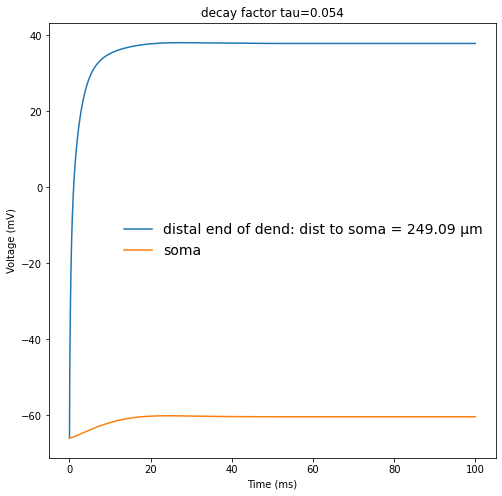

In [7]:
decayfactor = (dend_record[pltdend][-1]-h.v_init)/(soma_v[-1]-h.v_init)
if decayfactor > 1:
    decayfactor = 1 / decayfactor

# plot
plt.figure(figsize=(8,8))
plt.plot(t,dend_record[pltdend],label=f'distal end of dend: dist to soma = {round(disttosoma,2)} μm')
plt.plot(t,soma_v,label='soma')
plt.legend(fontsize = 14, frameon=False, loc=7)
plt.title(f"decay factor tau={round(decayfactor,4)}")
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (mV)')
plt.show()

